By this, you should have ``pandas``, ``numpy`` etc. installed. For this, we will install ``polyglot`` to analyze the text. The installation instructions apply for Linux.

```
$ sudo apt-get install libicu-dev
$ pip3 install --user polyglot morfessor pyicu pycld2
```

Install sentiment analysis and embeddings for Finnish language -- this might take some time:

```
$ python3
> from polyglot.download import downloader
> downloader.download("embeddings2.fi")
> downloader.download("sentiment2.fi")
```

To get rid of some annoying division by zero errors, we patch ``polyglot``. The install location can vary, but for example in my install, I'll open ``~/.local/lib/python3.5/site-packages/polyglot/text.py`` and change line 96 - the ``return`` of ``polarity`` function - to

```return sum(scores) / float(len(scores)) if len(scores) > 0 else np.nan```

and save.

The tweet file should be a line delimited JSON file - for testing it's better to create a smaller test data set. Add filename in ``FILENAME``, but _don't_ keep it in the directory that's going to Git, or add it to ``.gitignore`` if you insist.

In [44]:
import json
import pandas as pd 
import re 
import numpy as np
import matplotlib.pyplot as plt

FILENAME = "tweets3.json"

tweetfile = open(FILENAME, "r").read()
tweets = [json.loads(str(line)) for line in tweetfile.strip().split('\n')]

In [45]:
df = pd.DataFrame(tweets)
df.sort_values("created_at")

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
27816,None,None,Tue Oct 16 17:50:13 +0000 2018,"[0, 286]","{'symbols': [], 'hashtags': [], 'urls': [{'exp...",NaN,3,False,"Mankind must put a stop to war,or war will put...",None,...,False,NaN,NaN,NaN,1,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'default_profile_image': False, 'follow_reque..."
27815,None,None,Tue Oct 16 17:50:14 +0000 2018,"[0, 140]","{'symbols': [], 'hashtags': [], 'urls': [], 'u...",NaN,0,False,RT @MrTLexify: FREE BLACK OPS 4 GAME CODES (I ...,None,...,NaN,NaN,NaN,NaN,5349,False,"{'in_reply_to_screen_name': None, 'truncated':...","<a href=""http://twitter.com/download/android"" ...",False,"{'default_profile_image': False, 'follow_reque..."
27814,None,None,Tue Oct 16 17:50:18 +0000 2018,"[0, 114]",{'media': [{'expanded_url': 'https://twitter.c...,{'media': [{'expanded_url': 'https://twitter.c...,0,False,RT @InternetTodayTV: Black Ops 4 - WORST Selli...,None,...,False,NaN,NaN,NaN,17,False,"{'in_reply_to_screen_name': None, 'truncated':...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,"{'default_profile_image': False, 'follow_reque..."
27813,None,None,Tue Oct 16 17:50:19 +0000 2018,"[0, 140]","{'symbols': [], 'hashtags': [{'indices': [16, ...",NaN,0,False,RT @bmstores: ⚡ #COMPETITION TIME ⚡\n\nWe've t...,None,...,NaN,NaN,NaN,NaN,4990,False,"{'in_reply_to_screen_name': None, 'truncated':...","<a href=""http://twitter.com/#!/download/ipad"" ...",False,"{'default_profile_image': False, 'follow_reque..."
27812,None,None,Tue Oct 16 17:50:25 +0000 2018,"[0, 95]",{'media': [{'expanded_url': 'https://twitter.c...,{'media': [{'expanded_url': 'https://twitter.c...,0,False,RT @CODBattlesUS: Did Black ops 4 save Call of...,None,...,False,NaN,NaN,NaN,154,False,"{'in_reply_to_screen_name': None, 'truncated':...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,"{'default_profile_image': False, 'follow_reque..."
27811,None,None,Tue Oct 16 17:50:27 +0000 2018,"[0, 119]","{'symbols': [], 'hashtags': [{'indices': [49, ...",NaN,0,False,Consulter ma diffusion depuis ma PlayStation 4...,None,...,False,NaN,NaN,NaN,0,False,NaN,"<a href=""http://www.playstation.com"" rel=""nofo...",False,"{'default_profile_image': False, 'follow_reque..."
27810,None,None,Tue Oct 16 17:50:36 +0000 2018,"[0, 197]","{'symbols': [], 'hashtags': [], 'urls': [], 'u...",NaN,1,False,why does black ops 4 make my GPU work twice as...,None,...,NaN,NaN,NaN,NaN,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,"{'default_profile_image': False, 'follow_reque..."
27809,None,None,Tue Oct 16 17:50:40 +0000 2018,"[0, 282]","{'symbols': [], 'hashtags': [], 'urls': [], 'u...",NaN,0,False,Black Ops 4 Hot Fix Update: (Search &amp; Dest...,None,...,NaN,NaN,NaN,NaN,0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'default_profile_image': False, 'follow_reque..."
27808,None,None,Tue Oct 16 17:50:43 +0000 2018,"[0, 116]","{'symbols': [], 'hashtags': [{'indices': [46, ...",NaN,0,False,Check out my broadcast from my PlayStation 4! ...,None,...,True,NaN,NaN,NaN,0,False,NaN,"<a href=""http://www.playstation.com"" rel=""nofo...",False,"{'default_profile_image': False, 'follow_reque..."
27807,None,None,Tue Oct 16 17:50:44 +0000 2018,"[0, 74]","{'symbols': [], 'hashtags': [], 'urls': [], 'u...",NaN,0,False,RT @Attach: If you see this Black Ops 4 is you...,None,...,NaN,NaN,NaN,NaN,825,False,"{'in_reply_to_screen_name': None, 'truncated':...","<a href=""http://twitter.com/download/iphone"" r...",False,"{'default_profile_image': False, 'follow_reque..."


In [3]:
df.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'metadata', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'retweet_count',
       'retweeted', 'retweeted_status', 'source', 'truncated', 'user'],
      dtype='object')

Let's check for duplicates, based on the tweet id:

In [4]:
ids = set(df.id)
print("Original length: {} Unique ids: {}".format(len(df), len(ids)))

Original length: 24419 Unique ids: 24397


Let's drop the duplicates.

In [46]:
df = df.drop_duplicates(subset=['id'], keep='last')

Let's drop the retweets.

In [47]:
df = df[pd.isnull(df['retweeted_status'])]

We'll define some utility functions to handle the ``polyglot`` errors better, ie. if it can't detect the language or decides to divide by zero. We'll also strip ``@`` from usernames and ``#`` from tags, so they can be detected as entities or just ordinary words -- also we don't need the web links.

In [52]:
from polyglot.detect import Detector
from polyglot.text import Text

def detect_lang(text):
    try:
        return text.language.code
    except:
        return ''
    
def detect_polarity(text):
    try:
        polarity = text.polarity
        
        return polarity
    except:
        return np.nan

def tag_handle_link_strip(text):
    try:
        p = re.sub(r"(\#|\@|https?:\/\/[\w\d./]*.)", "", text)
        return p.strip()
    except:
        return text

def youtube_twitch_spam(text):
    spams = [
        "I liked a YouTube video",
        "I added a video to a YouTube playlist",
        "I'm now streaming on Twitch"
    ]
    
    return any(spam in text for spam in spams)

We'll apply the strip function to the tweet texts. Then we create ``polyglot.Text`` objects from the stripped texts. We attempt to detect the language and drop those, that aren't English. This will produce a lot of error messages for texts without reliable detection, by the way.

In [61]:
# line.full_text[line.display_text_range[0]:line.display_text_range[1]]
df['stripped_text'] = [tag_handle_link_strip(line.full_text) for idx, line in df.iterrows()]
df['polyglot_text'] = [Text(text) for text in df['stripped_text']]
df['detected_lang'] = df['polyglot_text'].apply(detect_lang)
df = df.drop(df[df['detected_lang'] != 'en'].index)

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

In [63]:
df = df.drop(df[df['stripped_text'].apply(youtube_twitch_spam)].index)

In [64]:
len(df)

9441

Let's get polarity values from the text objects. We'll also create a new dataframe containing only those entries with a detected polarity value.

In [65]:
df['polarity'] = [detect_polarity(text) for text in df['polyglot_text']]

df_polarity = df.dropna(subset=['polarity'])
len(df_polarity)

2465

Let's plot a histogram of the polarities:

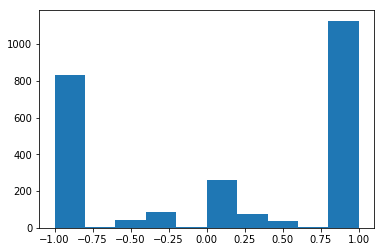

In [66]:
plt.hist(df_polarity['polarity']);